# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer 
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [159]:
data = pd.read_csv('../ML/datasets/adult_data_train.csv')
data = data.drop(['education', 'marital-status'], axis=1)
data

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Определите количество числовых и нечисловых признаков.

In [160]:
sorted(list(zip(data.columns, data.dtypes)))

[('age', dtype('int64')),
 ('capital-gain', dtype('int64')),
 ('capital-loss', dtype('int64')),
 ('education-num', dtype('int64')),
 ('fnlwgt', dtype('int64')),
 ('hours-per-week', dtype('int64')),
 ('label', dtype('int64')),
 ('native-country', dtype('O')),
 ('occupation', dtype('O')),
 ('race', dtype('O')),
 ('relationship', dtype('O')),
 ('sex', dtype('O')),
 ('workclass', dtype('O'))]

Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

0.7591753685503686

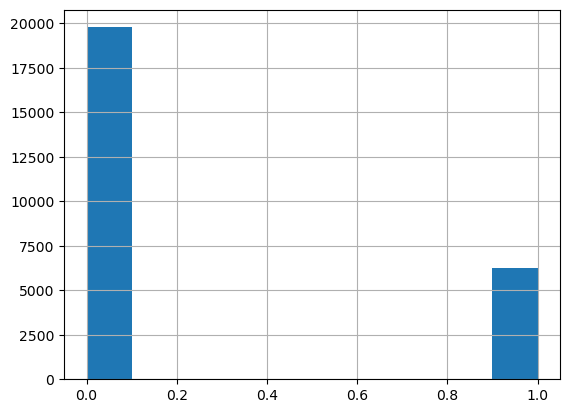

In [161]:
%matplotlib inline
data.label.hist()
label_0, label_1 = data.label.value_counts(0, 1)
label_0/(label_1 + label_0)

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных. 

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [162]:
data_int = data.loc[:, data.dtypes == 'int64']

In [163]:
X = data_int.drop(columns='label')
y = data_int['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

In [164]:
X_train['fnlwgt'].mean()

190199.1213648143

In [165]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [166]:
y_pred = knn.predict(X_test)
f1_score(y_test, y_pred)

0.3786557208825039

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [167]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
4236,33,267859,9,0,0,40
14636,28,230704,9,0,0,40
11353,68,140282,4,0,0,8
11715,26,262617,9,0,0,48
10105,53,260106,15,0,0,50
...,...,...,...,...,...,...
16105,18,200525,7,0,0,25
7227,64,149775,14,0,0,8
21529,42,85995,9,0,0,50
3475,21,243842,9,0,0,40


In [168]:
X_train_scaler[:, 1].mean()

0.12083109531574843

In [169]:
X_test

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
14490,39,177075,9,0,0,40
22814,17,57723,7,0,0,30
737,33,119176,10,0,0,40
4306,35,328301,12,0,0,40
2096,61,231323,10,0,0,40
...,...,...,...,...,...,...
3670,19,570002,10,0,0,25
3004,27,284196,6,0,0,40
19274,55,223594,10,7688,0,40
9127,50,74879,9,0,0,40


In [170]:
knn.fit(X_train_scaler, y_train)
y_pred_scaler = knn.predict(X_test_scaler)

In [171]:
f1_score(y_test, y_pred_scaler)

0.504655493482309

Видно, что после линейной нормировки качество выросло. 

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>). 

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

In [172]:
data_str = data.loc[:, data.dtypes != 'int64']
data_str.head(3)

,workclass,occupation,relationship,race,sex,native-country
0,Private,Exec-managerial,Husband,White,Male,United-States
1,Private,Exec-managerial,Not-in-family,White,Female,United-States
2,?,?,Not-in-family,White,Female,United-States


In [173]:
data_race = data_str['race'].value_counts()
pr, dr = zip(*data_race.items())
dr

(22283, 2462, 839, 238, 226)

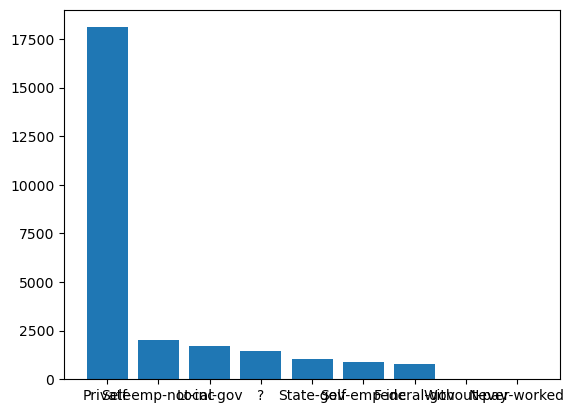

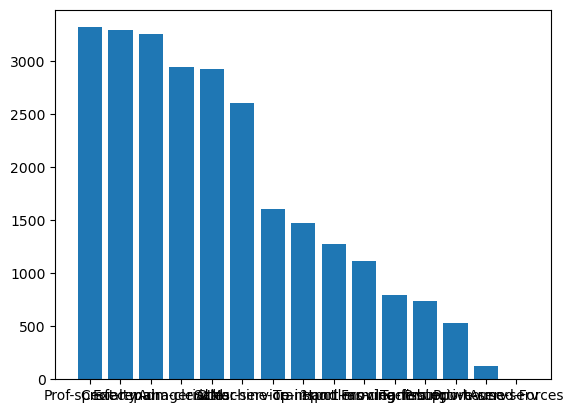

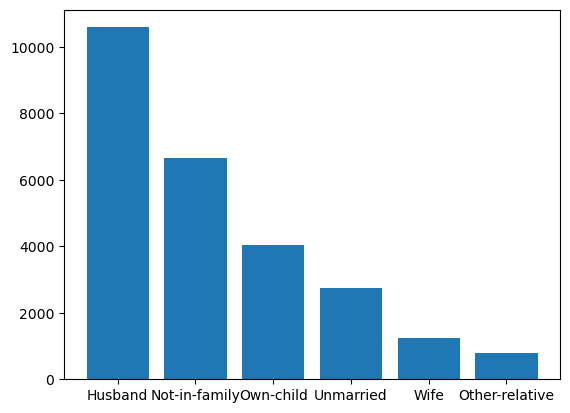

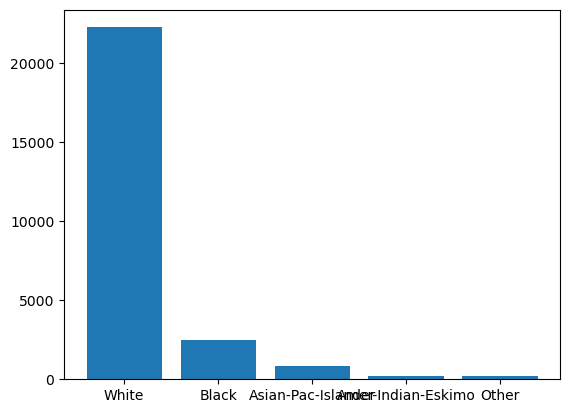

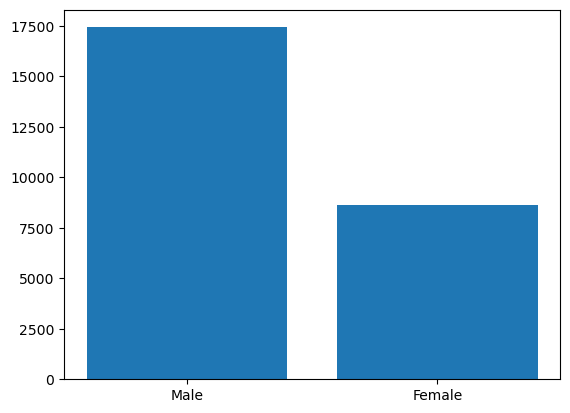

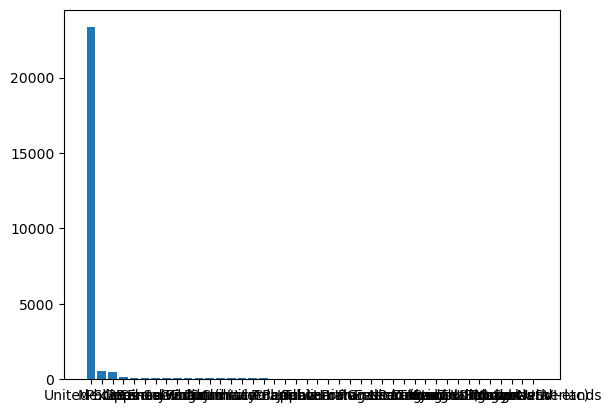

In [174]:
workclass = data_str['workclass'].value_counts()
plt.bar(*zip(*workclass.items()))
plt.show()

occupation = data_str['occupation'].value_counts()
plt.bar(*zip(*occupation.items()))
plt.show()

relationship = data_str['relationship'].value_counts()
plt.bar(*zip(*relationship.items()))
plt.show()

race = data_str['race'].value_counts()
plt.bar(*zip(*race.items()))
plt.show()

sex = data_str['sex'].value_counts()
plt.bar(*zip(*sex.items()))
plt.show()

native_country = data_str['native-country'].value_counts()
plt.bar(*zip(*native_country.items()))
plt.show()

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [175]:
data['workclass'].value_counts()
data_str_id = data_str[(data['workclass'] == '?') | 
						 					 (data['occupation'] == '?') | 
						           (data['native-country'] == '?')].index
data2 = data.drop(data_str_id, inplace=False)

Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них. 

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [176]:
data2 = pd.get_dummies(data2, columns=['workclass',	'occupation',	'relationship',	'race',	'sex', 'native-country'], drop_first=True)
data2

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,43,101950,14,0,0,45,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,40,24763,10,6849,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,24,113936,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,51,237630,9,7298,0,50,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26044,39,421633,10,0,0,30,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
26045,55,82098,9,0,0,55,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
26046,26,50053,13,0,0,55,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [177]:
X = data2.drop(columns='label')
y = data2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

In [178]:
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [179]:
knn.fit(X_train_scaler, y_train)
y_pred = knn.predict(X_test_scaler)
f1_score(y_test, y_pred)

0.6001838235294118

Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [180]:
for i in data:
	data.loc[(data[i] == '?'), i] = data[i].value_counts().index.tolist()[0]
data

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,Private,122244,9,Prof-specialty,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [181]:
data = pd.get_dummies(data, columns=['workclass', 'occupation', 'relationship', 'race', 'sex', 'native-country'], drop_first= True)

In [182]:
X = data.drop(columns = 'label')
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41,stratify=y)

In [183]:
scaler.fit(X_train)
X_train_scaler= scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [184]:
knn.fit(X_train_scaler, y_train)
y_predict = knn.predict(X_test_scaler)
f1_score(y_test,y_predict)

0.6099532113994045

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.

In [206]:
data_train = data
data = pd.read_csv('../ML/datasets/adult_data_reserved.csv')
data = data.drop(['education', 'marital-status'], axis=1)

In [203]:
for i in data:
	data.loc[(data[i] == '?'), i] = data[i].value_counts().index.tolist()[0]
data

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,31,Self-emp-inc,117963,16,Prof-specialty,Own-child,White,Male,0,0,40,United-States
1,20,Private,201490,10,Adm-clerical,Own-child,White,Male,0,0,40,United-States
2,78,Self-emp-inc,385242,13,Exec-managerial,Husband,White,Male,9386,0,45,United-States
3,32,Private,164197,13,Craft-repair,Husband,White,Male,0,0,44,United-States
4,61,Private,92691,9,Adm-clerical,Husband,White,Male,0,0,3,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
6508,42,Self-emp-not-inc,32185,13,Farming-fishing,Husband,White,Male,0,0,60,United-States
6509,34,Private,180714,10,Transport-moving,Husband,Black,Male,0,2179,40,United-States
6510,39,Private,202027,15,Prof-specialty,Husband,White,Male,0,0,45,United-States
6511,29,Private,125976,9,Sales,Unmarried,White,Female,0,0,35,United-States


In [187]:
data = pd.get_dummies(data, columns=['workclass', 'occupation', 'relationship', 'race', 'sex', 'native-country'], drop_first= True)

In [188]:
data_train = data_train.drop(columns='native-country_Holand-Netherlands')
data_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,43,101950,14,0,0,45,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,20,122244,9,0,0,28,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,40,24763,10,6849,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,24,113936,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26044,39,421633,10,0,0,30,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
26045,55,82098,9,0,0,55,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
26046,26,50053,13,0,0,55,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [189]:
X = data_train.drop(columns = 'label')
y = data_train['label']

In [190]:
scaler.fit(X)
X_train_scaler = scaler.transform(X)
X_test_scaler = scaler.transform(data)

In [201]:
knn.fit(X_train_scaler, y)
y_pred = knn.predict(X_test_scaler)
y_pred

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [212]:
with open('../ML/outputs/file_adult_reserve.txt', 'w') as f:
    f.write(f'{list(y_pred)}')